In [200]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import imutils
import pickle
import cv2
import os
import re

In [201]:
!rm -r ./frames
!mkdir ./frames

video_name = "4"
video = "./videos/" + video_name + ".mp4"

cap = cv2.VideoCapture(video)
cnt = 0

if (cap.isOpened() == False):
    print("File can not be opened")

ret, first_frame = cap.read()

while(cap.isOpened()):
    ret, frame = cap.read()

    if ret == True:
        roi = frame[:800,:]
        thresh = 600
        end = roi.shape[1] - thresh
        roi = roi[:, thresh:end]
        
        cv2.imshow("image", roi)
        
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
            
        cv2.imwrite('./frames/' + str(cnt) + '.png', roi)
        cnt = cnt + 1
    else: 
        break

cv2.destroyAllWindows()    

In [202]:
frames = os.listdir('frames/')
frames.sort(key=lambda f: int(re.sub('\D', '', f)))

images = []
for i in frames:
    img = cv2.imread('frames/' + i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.GaussianBlur(img, (5, 5), 0)
    images.append(img)

images=np.array(images)

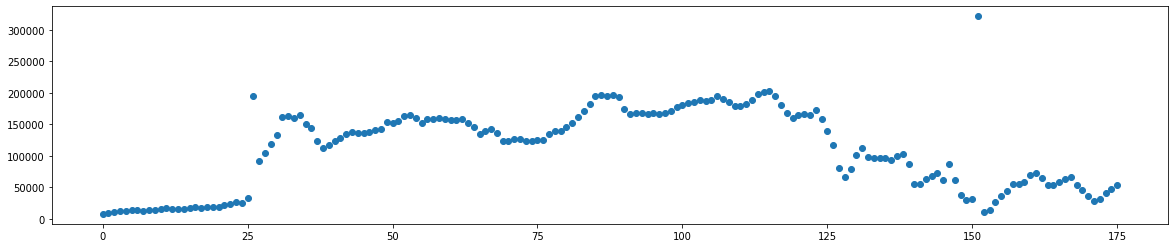

In [203]:
nonzero=[]
for i in range((len(images) - 1)):
    
    mask = cv2.absdiff(images[i], images[i + 1])
    _ , mask = cv2.threshold(mask, 50, 255, cv2.THRESH_BINARY)
    num = np.count_nonzero((mask.ravel()))
    nonzero.append(num)
    
    
x = np.arange(0, len(images) - 1)
y = nonzero

plt.figure(figsize = (20, 4))
plt.scatter(x, y)

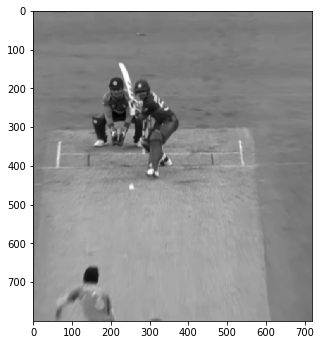

In [204]:
img = cv2.imread('frames/' + frames[10])
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (7, 7), 0)

plt.figure(figsize = (5, 10))
plt.imshow(gray, cmap = 'gray')

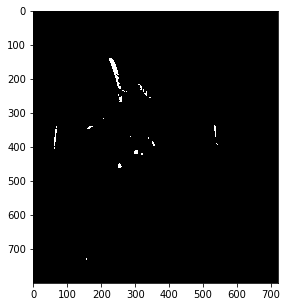

In [205]:
_, mask = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)


plt.figure(figsize = (5, 5))
plt.imshow(mask, cmap = 'gray')

In [206]:
contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

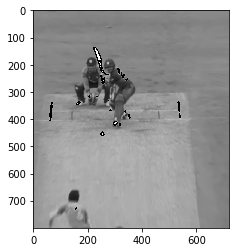

In [207]:
img_copy = np.copy(gray)
cv2.drawContours(img_copy, contours, -1, (0,0,0), 3)
plt.imshow(img_copy, cmap='gray')

In [208]:
def thresholding(image, v1, v2):
    _, mask = cv2.threshold(image, v1, v2, cv2.THRESH_BINARY)
    
    return mask

In [209]:
folders = os.listdir('images/')

images = []
labels = []
for folder in folders:
    files=os.listdir('images/'+folder)
    for f in files:
        img=cv2.imread('images/' + folder + '/' + f, 0)
        img=cv2.resize(img,(70, 70))

        images.append(img)
        labels.append(folder)

for i, label in enumerate(labels):
    if label == "ball":
        labels[i] = 0
    elif label == "bat":
        labels[i] = 1
    elif label == "miscellaneous":
        labels[i] = 2
        
images = np.array(images)
features = images.reshape(len(images), -1)
labels = np.array(labels)

In [210]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(features, labels, test_size = 0.2, stratify = labels, random_state = 42)

In [211]:
from sklearn.ensemble import RandomForestClassifier 
rfc = RandomForestClassifier(max_depth=30, criterion='entropy') 
rfc.fit(x_tr,y_tr)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [212]:
from sklearn.metrics import classification_report
y_pred = rfc.predict(x_val)
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.91      0.81      0.86       106
           1       1.00      0.72      0.84        57
           2       0.84      0.96      0.90       198

    accuracy                           0.88       361
   macro avg       0.92      0.83      0.86       361
weighted avg       0.89      0.88      0.88       361



In [213]:
ball_df = pd.DataFrame(columns=['frame', 'Frame Number', 'Frame Width', 'Frame Height', 'xmin', 'ymin', 'xmax', 'ymax'])
bat_df = pd.DataFrame(columns=['frame', 'Frame Number', 'Frame Width', 'Frame Height', 'xmin', 'ymin', 'xmax', 'ymax'])

thres_val = 200
threshold = 15 * 10e3


for idx in range(len(frames) - 1):
    !mkdir patch
    
    cnt = 0
    num = 10
    df = pd.DataFrame(columns=['frame', 'Frame Number', 'Frame Width', 'Frame Height', 'xmin', 'ymin', 'xmax', 'ymax'])
    
    img= cv2.imread('frames/' + frames[idx])
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (7, 7), 0)
    
    if(nonzero[idx] > threshold): 
        thres_val = 140
        
    mask = thresholding(gray, thres_val, 255)
        
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    for i in range(len(contours)):
        x, y, w, h = cv2.boundingRect(contours[i])

        numer = min([w, h])
        denom = max([w, h])
        ratio = numer / denom

        if(x >= num and y >= num):
            xmin, ymin = x - num, y - num
            xmax, ymax = x + w + num, y + h + num
        else:
            xmin, ymin = x, y
            xmax, ymax = x + w, y + h

        if((ratio >= 0.2) and (w <= 100) and (h <= 100)):    
            df.loc[cnt,'frame'] = frames[idx]
            df.loc[cnt,'Frame Number'] = idx
            df.loc[cnt,'Frame Height'] = img.shape[0]
            df.loc[cnt,'Frame Width'] = img.shape[1]
            df.loc[cnt,'xmin'] = xmin
            df.loc[cnt,'ymin'] = ymin
            df.loc[cnt,'xmax'] = xmax
            df.loc[cnt,'ymax'] = ymax

            cv2.imwrite("patch/" + str(cnt) + ".png", img[ymin:ymax, xmin:xmax])
            cnt = cnt + 1


    files=os.listdir('patch/')    
    if(len(files) > 0):
        files.sort(key=lambda f: int(re.sub('\D', '', f)))

        test=[]
        for file in files:
            img = cv2.imread('patch/' + file, 0)
            img = cv2.resize(img, (70, 70))
            test.append(img)

        test = np.array(test)

        test = test.reshape(len(test),-1)
        y_pred = rfc.predict(test)
        prob = rfc.predict_proba(test)        
        
        if 0 in y_pred:
            ind = np.where(y_pred == 0)[0]
            proba = prob[:,0]
            confidence = proba[ind]
            confidence = [i for i in confidence if i > 0.5]
            if(len(confidence) > 0):
                maximum = max(confidence)
                ball_file = files[list(proba).index(maximum)]

                img= cv2.imread('patch/' + ball_file)

                no = int(ball_file.split(".")[0])
                ball_df.loc[idx] = df.loc[no]
                
        if 1 in y_pred:      
            ind = np.where(y_pred == 1)[0]
            proba = prob[:,1]
            confidence = proba[ind]
            confidence = [i for i in confidence if i > 0.5]
            if(len(confidence) > 0):
                maximum = max(confidence)
                bat_file = files[list(proba).index(maximum)]

                img = cv2.imread('patch/' + bat_file)

                no = int(bat_file.split(".")[0])
                bat_df.loc[idx] = df.loc[no]
                                
    !rm -r ./patch

In [214]:
ball_df.dropna(inplace=True)
bat_df.dropna(inplace=True)

In [215]:
ball_df = ball_df.reset_index()
bat_df = bat_df.reset_index()

In [216]:
ball_files = ball_df['frame'].values
bat_files = bat_df['frame'].values

for idx in range(len(ball_files)):
    img = cv2.imread('frames/' + ball_files[idx])
    
    xmin = ball_df.loc[idx, 'xmin']
    ymin = ball_df.loc[idx, 'ymin']
    xmax = ball_df.loc[idx, 'xmax']
    ymax = ball_df.loc[idx, 'ymax']

    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255,0,0), 2)
    cv2.imwrite("frames/" + ball_files[idx], img)
    
for idx in range(len(bat_files)):
    img = cv2.imread('frames/' + bat_files[idx])
    
    xmin = bat_df.loc[idx, 'xmin']
    ymin = bat_df.loc[idx, 'ymin']
    xmax = bat_df.loc[idx, 'xmax']
    ymax = bat_df.loc[idx, 'ymax']

    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    cv2.imwrite("frames/" + bat_files[idx], img)

In [217]:
frames = os.listdir('frames/')
frames.sort(key=lambda f: int(re.sub('\D', '', f)))

frame_array=[]

for i in range(len(frames)):
    img = cv2.imread('frames/'+frames[i])
    height, width, layers = img.shape
    size = (width,height)
    frame_array.append(img)

out = cv2.VideoWriter('./processed_videos/' + video_name + ".mp4", cv2.VideoWriter_fourcc(*'DIVX'), 25, size)
 
for i in range(len(frame_array)):
    out.write(frame_array[i])
out.release()

In [218]:
ball_df = ball_df.drop(['index', 'frame'], axis = 1)
bat_df = bat_df.drop(['index', 'frame'], axis = 1)

In [219]:
ball_df.to_csv("./csv_files/ball_video" + video_name + ".txt", index = None, sep = ' ', mode = 'a')
bat_df.to_csv("./csv_files/bat_video" + video_name + ".txt", index = None, sep = ' ', mode = 'a')

In [220]:
ball_df.head()

,Frame Number,Frame Width,Frame Height,xmin,ymin,xmax,ymax
0,0,720,800,218,418,247,447
1,1,720,800,220,406,249,435
2,2,720,800,220,398,250,426
3,3,720,800,222,391,252,419
4,4,720,800,223,388,254,416


In [221]:
bat_df.head()

,Frame Number,Frame Width,Frame Height,xmin,ymin,xmax,ymax
0,2,720,800,244,240,298,275
1,3,720,800,242,233,297,275
2,4,720,800,240,226,295,273
3,5,720,800,238,217,293,271
4,6,720,800,236,204,291,268


In [222]:
filename = 'finalized_model.sav'
pickle.dump(rfc, open(filename, 'wb'))